In [1]:
# Add intellisense
%config IPCompleter.greedy=True

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
import datetime
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [4]:
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
# Import dataset
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import gscv2_dataset
train_dataset, validation_dataset, test_dataset = tfds.load('gscv2_dataset',
                                                            split=['train','validation','test'], 
                                                            shuffle_files=True,
                                                            as_supervised=True)

print(f"Train dataset has {len(list(train_dataset))} samples \nValidation dataset has {len(list(validation_dataset))} samples \nTest dataset has {len(list(test_dataset))} samples")

Train dataset has 38332 samples 
Validation dataset has 4567 samples 
Test dataset has 5019 samples


In [6]:
# Sanity check
"""
import wavio
import matplotlib.pyplot as plt

ds = test_dataset.take(1)
words = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'silence', 'unknown']

audio_sample = []
sample_count = 0

for audio, label in tfds.as_numpy(ds): 
    print(audio.shape)
    plt.imshow(audio.reshape((98,40)).T)
    plt.show()
    print(words[label])
#     for i in range(len(label)):
#         if label[i] == 10:
#             audio_sample.extend(audio[i])
#             print(wavio.write("myfile.wav", np.array(audio_sample), 16000, sampwidth=2))
#             sample_count += 1
#             break
            

# print(sample_count)

# import IPython
# IPython.display.Audio("myfile.wav")
"""

'\nimport wavio\nimport matplotlib.pyplot as plt\n\nds = test_dataset.take(1)\nwords = [\'down\', \'go\', \'left\', \'no\', \'off\', \'on\', \'right\', \'stop\', \'up\', \'yes\', \'silence\', \'unknown\']\n\naudio_sample = []\nsample_count = 0\n\nfor audio, label in tfds.as_numpy(ds): \n    print(audio.shape)\n    plt.imshow(audio.reshape((98,40)).T)\n    plt.show()\n    print(words[label])\n#     for i in range(len(label)):\n#         if label[i] == 10:\n#             audio_sample.extend(audio[i])\n#             print(wavio.write("myfile.wav", np.array(audio_sample), 16000, sampwidth=2))\n#             sample_count += 1\n#             break\n            \n\n# print(sample_count)\n\n# import IPython\n# IPython.display.Audio("myfile.wav")\n'

In [7]:
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
# res8-narrow model architecture
input_length = 98*40
classes = 12
channels = 1
columns = 40
rows = int(input_length / (columns * channels))

# Define graph
inputs = keras.Input(shape=(rows, columns, channels))
# Layer Conv0
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(inputs)
# Average pool layer
x = layers.AveragePooling2D(pool_size=(4,3), strides=(4,3), padding='same')(x)
# Residual block 1
y = x
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(x)
x = layers.Add(input_shape=x.shape)([x,y])
x = layers.BatchNormalization()(x)
# Residual block 2
y = x
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(x)
x = layers.Add(input_shape=x.shape)([x,y])
x = layers.BatchNormalization()(x)
# Residual block 3
y = x
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(19, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same',use_bias=False)(x)
x = layers.Add(input_shape=x.shape)([x,y])
x = layers.BatchNormalization()(x)
# Fully connected layer
x = layers.AveragePooling2D(pool_size=(25,14), strides=(25,14))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation='softmax', use_bias=True, name='y_pred')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="res8-narrow-original")

In [9]:
model.summary()

Model: "res8-narrow-original"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 98, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 40, 19)   171         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 25, 14, 19)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 14, 19)   3249        average_pooling2d[0][0]          
_______________________________________________________________________________

In [10]:
# this controls the learning rate
opt = Adam(lr=5e-3, beta_1=0.9, beta_2=0.999)

# train the neural network
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
logdir = os.path.join("logs_res8-narrow-original", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler

%tensorboard --logdir logs_res8-narrow-original

elist = [15,30,40]
decay = 0.2

def lr_time_based_decay(epoch, lr):
    if epoch in elist:
        lr = decay * lr
    return lr

Reusing TensorBoard on port 6009 (pid 122106), started 4 days, 20:22:52 ago. (Use '!kill 122106' to kill it.)

In [11]:
history = model.fit(x=train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback, lr_scheduler(lr_time_based_decay, verbose=1)])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.004999999888241291.
1198/1198 - 139s - loss: 1.1286 - accuracy: 0.6170 - val_loss: 1.2522 - val_accuracy: 0.6505
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.004999999888241291.
1198/1198 - 135s - loss: 0.5278 - accuracy: 0.8289 - val_loss: 0.8648 - val_accuracy: 0.7407
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004999999888241291.
1198/1198 - 139s - loss: 0.4170 - accuracy: 0.8677 - val_loss: 0.4321 - val_accuracy: 0.8673
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.004999999888241291.
1198/1198 - 139s - loss: 0.3598 - accuracy: 0.8859 - val_loss: 0.4041 - val_accuracy: 0.8800
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.004999999888241291.
1198/1198 - 133s - loss: 0.3250 - accuracy: 0.8979 - val_loss: 0.6772 - val_accuracy: 0.8086
Epoch 6/50

Epoch 00006: LearningRateScheduler reducing lear

1198/1198 - 127s - loss: 0.0498 - accuracy: 0.9868 - val_loss: 0.2403 - val_accuracy: 0.9402
Epoch 45/50

Epoch 00045: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
1198/1198 - 126s - loss: 0.0551 - accuracy: 0.9841 - val_loss: 0.2418 - val_accuracy: 0.9389
Epoch 46/50

Epoch 00046: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
1198/1198 - 126s - loss: 0.0507 - accuracy: 0.9863 - val_loss: 0.2420 - val_accuracy: 0.9396
Epoch 47/50

Epoch 00047: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
1198/1198 - 126s - loss: 0.0499 - accuracy: 0.9869 - val_loss: 0.2434 - val_accuracy: 0.9398
Epoch 48/50

Epoch 00048: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
1198/1198 - 126s - loss: 0.0512 - accuracy: 0.9855 - val_loss: 0.2435 - val_accuracy: 0.9387
Epoch 49/50

Epoch 00049: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
1198/1198 - 126s - loss: 0.0520 - accuracy: 0.9849 - va

In [12]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
157/157 [==============================] - 5s 33ms/step - loss: 0.2715 - accuracy: 0.9315
test loss, test acc: [0.27154308557510376, 0.931460440158844]


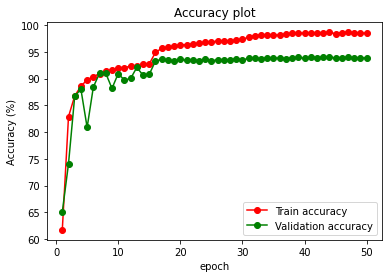

In [13]:
X = np.arange(1, EPOCHS+1)
plt.plot(X, np.array(history.history['accuracy'])*100, color='r', marker='o', label='Train accuracy')
plt.plot(X, np.array(history.history['val_accuracy'])*100, color='g', marker='o', label='Validation accuracy')

plt.xlabel("epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy plot")
plt.legend()

plt.show()

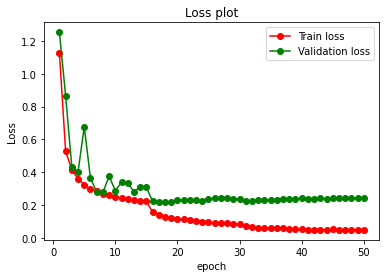

In [14]:
plt.plot(X, history.history['loss'], color='r', marker='o', label='Train loss')
plt.plot(X, history.history['val_loss'], color='g', marker='o', label='Validation loss')

plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend()

plt.show()

In [15]:
model.save('models/res8-narrow-original-tf.pb')

INFO:tensorflow:Assets written to: models/res8-narrow-original-tf.pb/assets


INFO:tensorflow:Assets written to: models/res8-narrow-original-tf.pb/assets


In [16]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/res8-narrow-original-tf.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpc64x19h_/assets


INFO:tensorflow:Assets written to: /tmp/tmpc64x19h_/assets


In [17]:
test_dataset = tfds.load('gscv2_dataset',
                         split=['test'], 
                         shuffle_files=True,
                         as_supervised=True)

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.

# iterator = iter(test_dataset)

def representative_dataset():
    for i in test_dataset[0]:
        yield([tf.cast(tf.reshape(i[0],(1,98,40,1)), dtype=tf.float32)])
        
converter.representative_dataset = representative_dataset
model_tflite_int8 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp2qoavkd4/assets


INFO:tensorflow:Assets written to: /tmp/tmp2qoavkd4/assets


In [18]:
# Save the model to disk
open('models/res8-narrow-original-tf-int8.tflite', "wb").write(model_tflite_int8)

34416

In [19]:
!xxd -i models/res8-narrow-original-tf-int8.tflite > models/res8-narrow-original-tf-int8.cc

In [20]:
test_dataset = tfds.load('gscv2_dataset',
                         split=['test'], 
                         as_supervised=True)

test_ds = []
for i in test_dataset[0]:
    test_ds.append(tf.cast(tf.reshape(i[0],(98,40,1)), dtype=tf.float32))
    
test_ds = np.array(test_ds)

In [21]:
# Evaluate performance of quantized model
def predict_tflite(lite_model, x_test_):
    # Prepare the test data
    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=lite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])
    
    print(f"x_test = {x_test_.reshape(-1)}\nOuput scale = {input_scale}, zero point ={input_zero_point}")
    
#     mfcc_data = ",".join(str(x) for x in x_test_.reshape(-1))

#     with open('mfcc_data.h','w+') as f:
#         f.write("""#ifndef INC_MFCC_DATA_H_
# #define INC_MFCC_DATA_H_

# #define WAVE_DATA {""")
#         f.write(mfcc_data + "};")
#         f.write("""

# #endif
# """)
    
    # Invoke the interpreter
    y_pred = np.empty((x_test_.shape[0],12), dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    
    print(f"y_prediction = {y_pred}\nOuput scale = {output_scale}, zero point ={output_zero_point}")
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
    global model, representative_dataset
    y_pred = predict_tflite(model_tflite_int8, representative_dataset)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).n79812umpy()
    return loss

In [22]:
y_test_pred_tf = model.predict(test_ds)
print(y_test_pred_tf.shape)

(5019, 12)


In [23]:
y_test_pred_no_quant_tflite = predict_tflite(tflite_model, test_ds)
print(y_test_pred_no_quant_tflite.shape)

x_test = [-105.158745      9.235392     -2.000153   ...   -0.24545969   -0.41785854
   -0.30703047]
Ouput scale = 0.0, zero point =0
y_prediction = [[1.36653524e-08 2.05900325e-10 3.14564997e-12 ... 1.19786705e-14
  1.83380981e-15 6.81122936e-09]
 [1.27788896e-14 1.95865993e-15 9.99996424e-01 ... 1.01031344e-06
  5.34013954e-14 2.65402423e-06]
 [2.39683404e-16 1.59457298e-15 1.36798306e-07 ... 1.35907180e-20
  5.21358308e-16 4.13253293e-10]
 ...
 [3.27803207e-07 3.50280220e-06 9.01246585e-06 ... 5.63385765e-06
  2.89399964e-06 1.87999289e-02]
 [6.44390305e-11 2.89993324e-11 1.84893076e-06 ... 9.99997973e-01
  1.61788791e-10 7.45951638e-08]
 [6.22471794e-03 6.62183482e-03 7.69004910e-05 ... 3.42872286e-09
  1.48361212e-10 3.89178127e-01]]
Ouput scale = 0.0, zero point =0
(5019, 12)


In [24]:
y_test_pred_tflite = predict_tflite(model_tflite_int8, test_ds)
print(y_test_pred_tflite.shape)

x_test = [-21  93  81 ...  83  83  83]
Ouput scale = 0.9945561289787292, zero point =84
y_prediction = [[-128 -128 -128 ... -128 -128 -128]
 [-128 -128  127 ... -128 -128 -128]
 [-128 -128 -128 ... -128 -128 -128]
 ...
 [-128 -128 -128 ... -128 -128   99]
 [-128 -128 -127 ...  127 -128 -128]
 [ -51  -27 -128 ... -128 -128 -112]]
Ouput scale = 0.00390625, zero point =-128
(5019, 12)


In [25]:
y_original = []
for i in test_dataset[0]:
    y_original.append(i[1])

y_original = np.array(y_original)
print(y_original.shape)

(5019,)


In [26]:
y_pred = np.argmax(y_test_pred_tf, axis=1)
y_test_pred_no_quant = np.argmax(y_test_pred_no_quant_tflite, axis=1)
y_test_pred_int8 = np.argmax(y_test_pred_tflite, axis=1)

<AxesSubplot:>

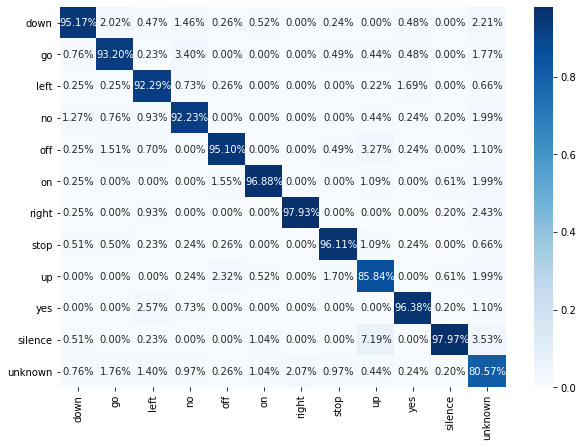

In [27]:
# Confusion matrix for TF model
cm1 = confusion_matrix(y_original,y_pred)
cm1 = cm1/np.sum(cm1,axis=0)
word_list = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'silence', 'unknown']
df_cm = pd.DataFrame(cm1, index = word_list, columns = word_list, dtype=float)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.2%', cmap='Blues')

<AxesSubplot:>

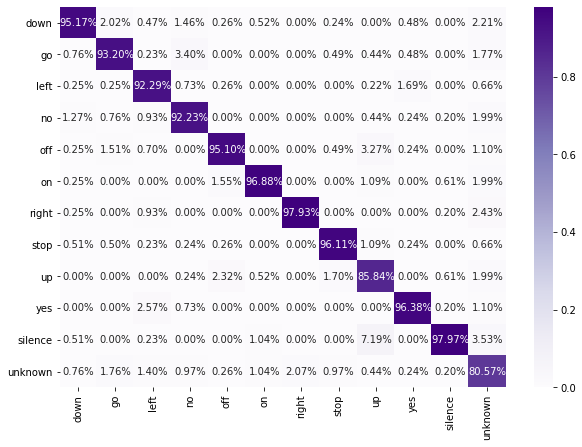

In [28]:
# Confusion matrix for TF lite model without quantization
cm2 = confusion_matrix(y_original,y_test_pred_no_quant)
cm2 = cm2/np.sum(cm2,axis=0)
word_list = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'silence', 'unknown']
df_cm = pd.DataFrame(cm2, index = word_list, columns = word_list, dtype=float)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.2%', cmap='Purples')

<AxesSubplot:>

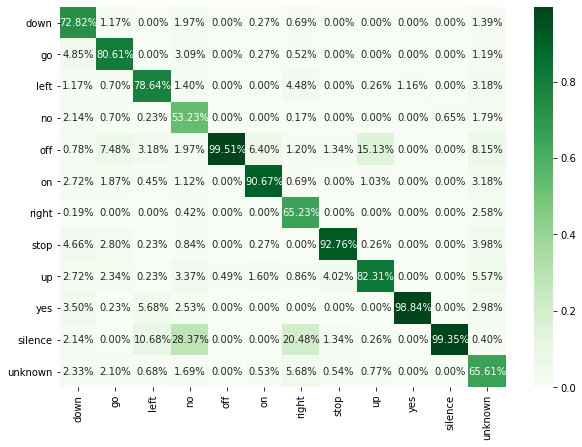

In [29]:
# Confusion matrix for TF lite model with 8b quantization
cm3 = confusion_matrix(y_original,y_test_pred_int8)
cm3 = cm3/np.sum(cm3,axis=0)
word_list = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'silence', 'unknown']
df_cm = pd.DataFrame(cm3, index = word_list, columns = word_list, dtype=float)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.2%', cmap='Greens')

In [30]:
# Calculate size
size_tf = os.path.getsize("models/res8-narrow-original-tf.pb/saved_model.pb")
size_no_quant_tflite = os.path.getsize("models/res8-narrow-original-tf.tflite")
size_tflite = os.path.getsize("models/res8-narrow-original-tf-int8.tflite")

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


Size                           
Model                                                             
TensorFlow                 532391 bytes                           
TensorFlow Lite            89068 bytes   (reduced by 443323 bytes)
TensorFlow Lite Quantized   34416 bytes   (reduced by 54652 bytes)

In [31]:
# Calculate accuracy
acc_tf = np.trace(cm1)*100/np.sum(cm1)
acc_tflite = np.trace(cm2)*100/np.sum(cm2)
acc_tflite_int8 = np.trace(cm3)*100/np.sum(cm3)

# Compare accuracy
df = pd.DataFrame.from_records(
    [["TensorFlow", acc_tf],
     ["TensorFlow Lite", acc_tflite],
     ["TensorFlow Lite Quantized", acc_tflite_int8]],
     columns = ["Model", "Accuraccy (\%)"], index="Model").round(4)
df

Accuraccy (\%)
Model                                    
TensorFlow                        93.3055
TensorFlow Lite                   93.3055
TensorFlow Lite Quantized         81.6302

In [32]:
# Test a sample
import librosa

def mfcc(audio_input):
    n_fft = 512
    hop_length = 160
    window_length = 480
    sr = 16000
    n_dct_filters = 40
    n_mels = 40

    f_min = 20
    f_max = 4000

    dct_filters = librosa.filters.dct(n_dct_filters, n_mels)
    mel_basis = librosa.filters.mel(sr, n_fft, n_mels=n_mels, fmin=f_min, fmax=f_max, htk=True)
    
    audio_input = np.concatenate((audio_input,np.zeros(16000-audio_input.shape[0])))
    z = lambda t: np.pad(t,pad_width=(n_fft-window_length)//2,mode='reflect')
    n_features = (sr - window_length)//hop_length + 1

    y_padded = np.zeros((n_features,n_fft))
        
    # Reflect pad each window
    for i in range(n_features):
        y_padded[i][:] = z(audio_input[i*hop_length:i*hop_length+window_length])

    y_padded = y_padded.reshape(-1)

    # Compute spectrogram
    spectrogram = np.abs(librosa.stft(
                        y_padded,
                        n_fft=n_fft,
                        hop_length=n_fft,
                        win_length=n_fft,
                        center=False,
                        window='hann',
                        pad_mode='reflect'))**2

    # Compute mel spectrogram
    mel_spec = np.dot(mel_basis, spectrogram)
    # Take log
    mel_spec[mel_spec > 0] = np.log(mel_spec[mel_spec > 0])

    mfcc = [np.matmul(dct_filters, x) for x in np.split(mel_spec, mel_spec.shape[1], axis=1)]
    mfcc = np.array(mfcc, order="F").reshape((n_features,n_mels,1))
    mfcc = np.int8(mfcc/2) #Q8.-1
    return mfcc

import pydub

word_list = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'silence', 'unknown']

file_obj = '/home/shyama/Desktop/mtp/dataset/dataset_v2/right/8fe52b97_nohash_1.wav'
label_original = 'right'
wav_in = np.array(pydub.AudioSegment.from_file(file_obj,format='wav').get_array_of_samples())
nn_input = mfcc(wav_in/2**15)
y_p = predict_tflite(model_tflite_int8, nn_input.reshape((1,98,40,1)))

# wav_str = ",".join(str(x) for x in wav_in)

# with open('wav_data.h','w+') as f:
#     f.write("""#define WAVE_DATA {""")
#     f.write(wav_str + "};")

print(f"Original output: {label_original}, Predicted output: {np.argmax(y_p)},{word_list[np.argmax(y_p)]}")
# print(wav_str)

x_test = [48 86 84 ... 84 84 84]
Ouput scale = 0.9945561289787292, zero point =84
y_prediction = [[-128 -128 -128 -127 -128 -128   32 -128 -128 -128 -128  -34]]
Ouput scale = 0.00390625, zero point =-128
Original output: right, Predicted output: 6,right
